In [3]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#指定默认字体
# matplotlib.rcParams['font.sans-serif'] = ['SimHei']
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Microsoft Yahei']
matplotlib.rcParams['font.family']='sans-serif'
#解决负号'-'显示为方块的问题
matplotlib.rcParams['axes.unicode_minus'] = False

mu = np.arange(0.1, 0.81, 0.1)
learn = np.arange(0.2, 1.01, 0.2)
radius = np.arange(3, 11.1, 2)
sense = np.arange(0.2, 1.01, 0.2)
year = np.arange(2006,2017,1)
print(mu)
print(learn)
print(radius)
print(sense)
print(year)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
[0.2 0.4 0.6 0.8 1. ]
[ 3.  5.  7.  9. 11.]
[0.2 0.4 0.6 0.8 1. ]
[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016]


In [7]:
simulation = pd.read_csv(open(r'../data/abm_farmer/simulations.csv'))
sim = simulation[['id','mu','learn','sense','radius']]
country = pd.read_csv(r'../data/abm_farmer/country_traces.csv')
# farmerInit = pd.read_csv(open(r'../data/abm_farmer/farmer_inits.csv'))
# farmerAnchor = pd.read_csv(r'../data/abm_farmer/farmer_anchors.csv')
country['time'] = country['time'].apply(lambda x: x.split('-')[0])

## 0.  连表筛选数据

In [4]:
def getSimId(mu, learn, sense, radius):
    temp = sim[(sim['mu']==mu) & (sim['learn']==learn) & (sim['sense']==sense) & (sim['radius']==radius)]
    return temp['id'].values[0]
# sim = simulation[['id','mu','learn','sense','radius']][(simulation['mu']==0.3) & (simulation['learn']==0.2) & (simulation['sense']==0.2) & (simulation['radius']==3)]
# print(sim['id'].values[0])
# print(sim.loc[0:3,'id']) #基于标签      iloc[0:1, 2:5] 完全是基于索引
# print(getSimId(0.3,0.2,0.2,5))

def getCountryData(simId, sortedBy):
    temp = country[country['sim_id'] == simId].sort_values(by=sortedBy)
    return temp
# temp = country[country['sim_id'] == getSimId(0.3,0.2,0.2,3)].sort_values(by='time')
# print(temp)
# print(getCountryData(getSimId(0.3,0.2,0.2,5), 'time'))

## 1. 基准模型

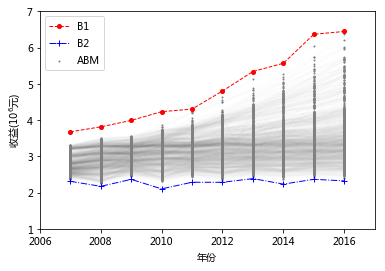

In [8]:
year = np.arange(2007,2017,1)

plotX = []
plotY = []
plotMaxY = []
plotMinY = []

for y in year:
    strY = str(y)
    tempY = country[country['time']==strY]['crop_income'].values
    tempX = [y] * len(tempY)
    plotX.append(tempX)
    plotY.append(tempY)
    plotMaxY.append(tempY.max())
    plotMinY.append(tempY.min())
    

plt.ylabel(r'收益($10^6$元)')
plt.xlabel(r'年份')

plotY = np.array(plotY) / 1e6
np.random.seed(666)
plotB1Y = np.array(plotMaxY) / 1e6 + np.random.normal(0.0,0.2, size=len(plotMaxY)) + 0.2
np.random.seed(20)
plotB2Y = np.array(plotMinY) / 1e6 + np.random.normal(0.0,0.05, size=len(plotMaxY)) - 0.1

plt.scatter(plotX, plotY, s=1, c='grey', label='ABM')
plt.plot(plotX, plotY, linewidth=2.0, color='grey', alpha=0.01)

plt.plot(year, plotB1Y, 'ro--', linewidth=1, markersize=4, label='B1')
plt.plot(year, plotB2Y, 'b+-.', linewidth=1, markersize=6, label='B2')

plt.legend()
plt.axis([2006, 2017, 1, 7])

plt.show()

## 2. 旱地占mu比单因素分析

In [11]:
print(learn, radius, sense)

[0.2 0.4 0.6 0.8 1. ] [ 3.  5.  7.  9. 11.] [0.2 0.4 0.6 0.8 1. ]


In [31]:
def filterCountry(filters, replaceSimIdBy):
    '''
        function : filter country table with filters, replace the field 'sim_id' with replaceSimIdBy
        filters : dictionnary, key must equal with the country and sim field
        repalceSimIdBy : the new DataFrame sim_id => filterValue
        example:
            mu = [0.3,0.4,...]
            >> temp = filterCountry({'learn':0.6, 'radius':7., 'sense':0.6}, 'mu')
            >> print(temp)
            id  sim_id  time  precipitation  crop_irrigation  rice_irrigation  \
    3962  3963     0.3  2006         398.50        299911.95        270254.82   
    3966  3967     0.3  2007         455.70        462937.64        395925.46   
    3970  3971     0.3  2008         475.98        328978.88        290908.39   
    3974  3975     0.3  2009         265.96        469009.19        401609.49 
    '''
    keys = filters.keys()
    values = filters.values()
    condition = 1
    for key, value in zip(keys, values):
        condition = condition & (abs(sim[key]-value) < 0.01)
    simMu = sim[condition]
    simIds = simMu['id'].values
    countryMu = country[country['sim_id'].isin(simIds)]
    countryMu['sim_id'] = countryMu['sim_id'].apply(lambda x: simMu[simMu['id']==x][replaceSimIdBy].values[0])
    return countryMu

# condition = (abs(sim['learn']-0.6) < 0.01) & (abs(sim['radius']-7.) < 0.01) & (abs(sim['sense']-0.6) < 0.01)
# simMu = sim[condition]
# simIds = simMu['id'].values
# countryMu = country[country['sim_id'].isin(simIds)]
# countryMu['sim_id'] = countryMu['sim_id'].apply(lambda x: simMu[sim['id']==x]['mu'].values[0])
# print(countryMu, countryMu.columns)
# temp = filterCountry({'learn':0.6, 'radius':7., 'sense':0.6}, 'mu')